In [1]:
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.ticker as tick
import control
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["font.family"] = "serif"
mp.rcParams["text.usetex"] = True
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100

In [127]:
class LeadCompensator:
    
    def __init__(self, w):
        self.w = w
        self.s = 1j*w
        
    def initTransferFunc(self, G):
        self.G = G
        
    def initNegativeFeedback(self, gain):
        self.k = gain
        self.H = self.G(self.s)/(1 + self.k*self.G(self.s))
        self.magnitude = 20*np.log10(self.H)
        self.phase = np.degrees(np.arctan2(self.H.imag, self.H.real))
        
    def BodePlot(self, save=False, savename=None):
        fig = mp.figure(figsize=(5*16/9, 5*1.25))
        
        ax = fig.add_subplot(211)
        ax.plot(self.w, self.magnitude)
        ax.set_xscale("log")
        ax.grid(True, which="both")
        ax.set_ylabel("magnitude (dB)")
        ax.set_xlim(self.w.min(), self.w.max())
        ax.set_ylim(self.magnitude.min(), self.magnitude.max()+2)
        ax.xaxis.set_major_formatter(tick.NullFormatter())
        
        ax = fig.add_subplot(212)
        ax.plot(self.w, self.phase)
        ax.set_xscale("log")
        ax.grid(True, which="both")
        ax.set_xlabel("angular frequency (rad/s)")
        ax.set_ylabel("phase (deg)")
        ax.set_xlim(self.w.min(), self.w.max())
        ax.set_ylim(self.phase.min()-1, self.phase.max()+1)
        
        mp.tight_layout()
        if save:
            mp.savefig(savename, dpi=300, bbox_inches="tight")
        mp.show()
        
    def initDesired(self, percent_overshoot, Tp):
        self.zeta = -np.log(percent_overshoot)/np.sqrt(np.pi**2 + \
                                            np.log(percent_overshoot)**2)
        self.wn = np.pi/(Tp * np.sqrt(1 - self.zeta**2))
        self.sd = -self.zeta*self.wn + 1j*self.wn*np.sqrt(1 - self.zeta**2)
        self.Gsd = self.G(self.sd)
        phiGsd = np.arctan2(self.Gsd.imag, self.Gsd.real)
        self.phid = np.pi - phiGsd
        
    def initCompensator(self):
        self.alpha = np.arctan2(np.sqrt(1 - self.zeta**2), self.zeta)
        self.zc = -self.wn*np.sqrt(1 - self.zeta**2) * \
                    np.tan((self.alpha - self.phid)/2) - self.zeta*self.wn
        self.pc = -self.wn*np.sqrt(1 - self.zeta**2) * \
                    np.tan((self.alpha + self.phid)/2) - self.zeta*self.wn
        self.K = 1/abs(self.Gsd*(self.sd + self.zc)/(self.sd + self.pc))

In [128]:
# 2015-03116

def G(s):
    return 3/(s**2 + s)

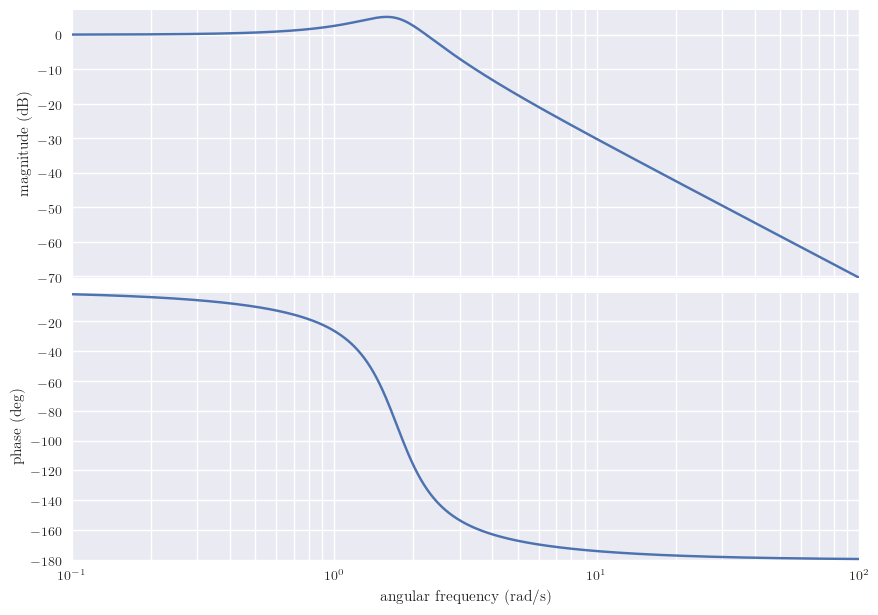

In [129]:
w = np.logspace(-1, 2, 500)
sys = LeadCompensator(w)
sys.initTransferFunc(G)
sys.initNegativeFeedback(1)
sys.BodePlot(True, "sys_bode.png")
sys.initDesired(0.4, 0.25)
sys.initCompensator()

In [135]:
sys.K

82.11180079605842

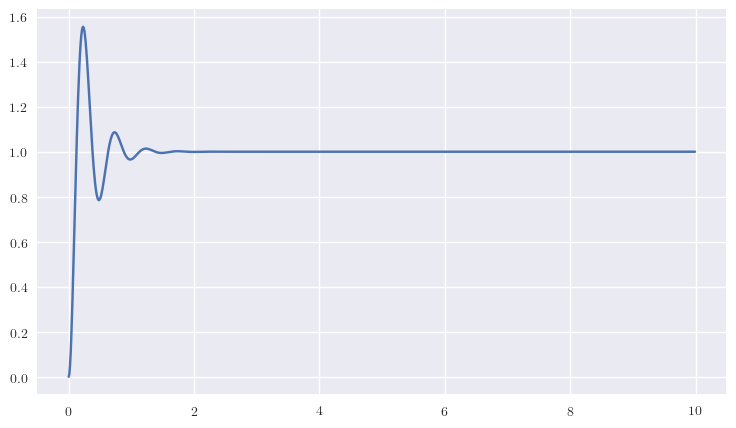

In [136]:
sys = control.tf([3], [1, 1, 0])
sys_comp = control.tf([1, 8.94], [1, 19.18])
sys_cascade = control.series(82.11, sys_comp, sys)
sys_fb = control.feedback(sys_cascade, 1)
t = np.arange(0, 10, 0.01)
t, y = control.step_response(sys_fb, t)

mp.plot(t, y)
mp.show()